# Salary Predictions Based on Job Descriptions

### Use case definition

Prediciting the Salary of a given resource using the available data.
Our Measurement of sucess for this effort is the Mean Square Error and let's target for an MSE < 350

#### Import reqd libraries

In [54]:
#import libraries
import os
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
sns.set()

__author__ = "Anup C"

In [2]:
os.chdir('F:\Data Science Dream Job\Portfolio Projects\Project_1_05192019')
os.getcwd()

'F:\\Data Science Dream Job\\Portfolio Projects\\Project_1_05192019'

## Data Load and EDA

In [3]:
test_features = pd.read_csv('test_features.csv')
train_features = pd.read_csv('train_features.csv')
train_salaries = pd.read_csv('train_salaries.csv')

In [5]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
train_features.shape

(1000000, 8)

In [6]:
train_features.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object

In [8]:
train_salaries.shape

(1000000, 2)

In [9]:
test_features.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [4]:
raw_train_data = pd.merge(train_features,train_salaries, how = 'left', on = ['jobId'])
raw_train_data.head(5)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


## Keeping only the variables of interest

In [5]:
raw_train_data = raw_train_data.drop(['jobId','companyId'],axis = 1)
raw_train_data.describe(include='all')

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
count,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000
unique,8,5,9,7,NaN,NaN,NaN
top,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN,NaN
freq,125886,236976,532355,143206,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,11.992386,49.529260,116.061818
std,NaN,NaN,NaN,NaN,7.212391,28.877733,38.717936
min,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,6.000000,25.000000,88.000000
50%,NaN,NaN,NaN,NaN,12.000000,50.000000,114.000000
75%,NaN,NaN,NaN,NaN,18.000000,75.000000,141.000000


In [256]:
raw_train_data['jobType'].value_counts()

SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64

In [257]:
raw_train_data['degree'].value_counts()

HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64

In [258]:
raw_train_data['major'].value_counts()

NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64

In [306]:
raw_train_data['salary'].where(raw_train_data['jobType'] == 'MANAGER').mean()

115.36759616691043

In [315]:
raw_train_data['jobType'].where((raw_train_data['major'] == 'NONE') & (raw_train_data['degree'] == 'NONE')).value_counts()

JANITOR           62544
SENIOR            25117
MANAGER           25092
CEO               24898
CTO               24882
VICE_PRESIDENT    24825
JUNIOR            24782
CFO               24714
Name: jobType, dtype: int64

## Adding New Features

Based on intuition, we can add the below two additional features to the existing list.
The model might not be accurate with the existing features, because the salaries for all job types do not follow an exact linear trend. Also, there are a lot of records with education listed as NONE.
It can be treated as no major or no high school or just no entry for that particular person.

We can remove those variables if there is any multicollinearity later!

In [6]:
def profile(df):
    if (df['major'] == 'NONE' and df['degree'] == 'NONE') or df['salary'] < 70:
        return 'Drop Out'
    if df['degree'] == 'DOCTORAL' and (df['jobType'] == 'CTO' or df['jobType'] == 'CFO' or df['jobType'] == 'CEO' or \
    df['jobType'] == 'VICE_PRESIDENT') or df['salary'] > 200:
        return 'Executives'
    if df['jobType'] == 'SENIOR' or df['jobType'] == 'MANAGER' or df['salary'] > 100 and \
    (df['degree'] == 'DOCTORAL' or df['degree'] == 'MASTERS' or df['degree'] == 'BACHELORS'):
        return 'Management'
    if df['jobType'] == 'JUNIOR' and df['salary'] < 100 and \
    (df['degree'] == 'HIGH_SCHOOL' or df['degree'] == 'BACHELORS'):
        return 'Freshers'
    else:
        return 'Average Employee'

In [7]:
def experience_buckets(df):
    if df['yearsExperience'] > 0 and df['yearsExperience'] <= 5:
        return '0-5'
    if df['yearsExperience'] > 5 and df['yearsExperience'] <= 10:
        return '5-10'
    if df['yearsExperience'] > 10 and df['yearsExperience'] <= 15:
        return '10-15'
    if df['yearsExperience'] > 15 and df['yearsExperience'] <= 20:
        return '15-20'
    else:
        return '>20'        

In [8]:
raw_train_data['profile'] = raw_train_data.apply(profile, axis=1)
raw_train_data.profile.value_counts()

Management          395740
Drop Out            296513
Average Employee    173147
Executives          113383
Freshers             21217
Name: profile, dtype: int64

In [9]:
raw_train_data['experience_buckets'] = raw_train_data.apply(experience_buckets, axis=1)
raw_train_data.experience_buckets.value_counts()

0-5      200550
5-10     200527
15-20    199882
>20      199660
10-15    199381
Name: experience_buckets, dtype: int64

In [10]:
nodup_train_data = raw_train_data.drop_duplicates()
nodup_train_data.dtypes

jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
profile                object
experience_buckets     object
dtype: object

In [11]:
# checking for NULL values across all fields
nodup_train_data.isnull().sum()

jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
profile                0
experience_buckets     0
dtype: int64

In [12]:
train_data = nodup_train_data.copy()
train_data['salary'] = train_data['salary'].replace(',', '').astype(int)
train_data = train_data.loc[train_data['salary'] > 0]
train_data.shape

(989185, 9)

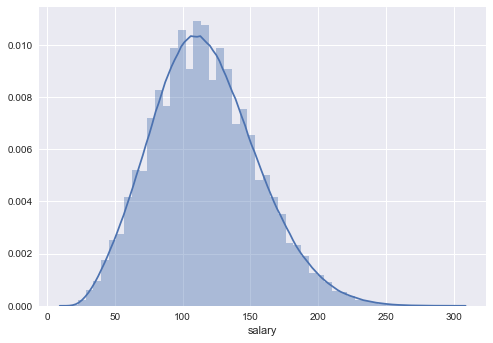

In [20]:
sns.distplot(train_data['salary'])
plt.show()

Let's get rid of records with salaries more than 250k to treat the skewness in the data.
This is to relax the assumption of linear regression, which requires our target to be normally distributed

Shape of Train data set after cleaning:  (988395, 9)


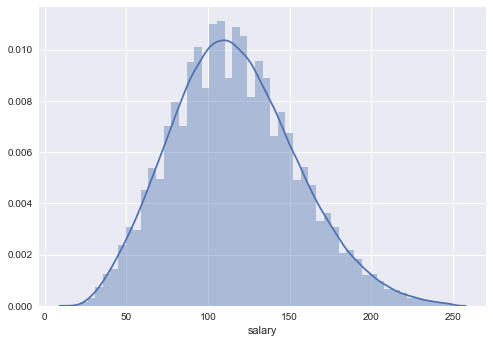

In [13]:
train_data = train_data.loc[train_data['salary'] <= 250]
print ('Shape of Train data set after cleaning: ', train_data.shape)
sns.distplot(train_data['salary'])
plt.show()

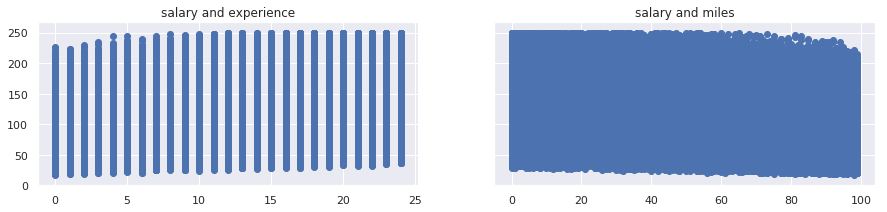

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize =(15,3))
ax1.scatter(train_data['yearsExperience'],train_data['salary'])
ax1.set_title('salary and experience')
ax2.scatter(train_data['milesFromMetropolis'],train_data['salary'])
ax2.set_title('salary and miles')
plt.show()

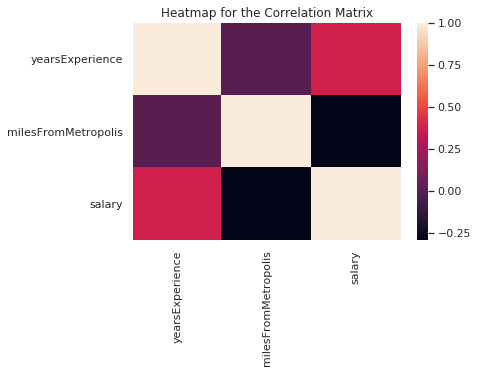

In [28]:
corr = train_data.corr()
sns.heatmap(corr,
           xticklabels = corr.columns.values,
           yticklabels = corr.columns.values)
plt.title('Heatmap for the Correlation Matrix')
# corr
plt.show()

## Multicollinearity

In [49]:
variables = train_data[['salary','yearsExperience','milesFromMetropolis']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,4.983096,salary
1,4.435979,yearsExperience
2,2.606374,milesFromMetropolis


## Create Dummy Variables

In [14]:
train_data = pd.get_dummies(train_data, drop_first=True)
train_data.head(5)

,yearsExperience,milesFromMetropolis,salary,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,industry_SERVICE,industry_WEB,profile_Drop Out,profile_Executives,profile_Freshers,profile_Management,experience_buckets_10-15,experience_buckets_15-20,experience_buckets_5-10,experience_buckets_>20
0,10,83,130,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,3,73,101,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,10,38,137,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,8,17,142,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,8,16,163,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [51]:
variables = train_data.drop(['salary'],axis=1)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,11.135160,yearsExperience
1,3.775948,milesFromMetropolis
2,1.836403,jobType_CFO
3,1.842511,jobType_CTO
4,2.286111,jobType_JANITOR
5,2.314793,jobType_JUNIOR
6,2.238523,jobType_MANAGER
7,2.235518,jobType_SENIOR
8,1.831832,jobType_VICE_PRESIDENT
9,3.224030,degree_DOCTORAL


In the row 19, looks like the major_NONE variable has high VIF and its better to drop it.
In the field Major - None can be missing entry or the person might not have a Major. Nonetheless, 
in the benefit of doubt I will get rid of this variable.

In [55]:
variables = train_data.drop(['degree_NONE','major_NONE','yearsExperience','salary'],axis=1)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,3.710334,milesFromMetropolis
1,1.762522,jobType_CFO
2,1.767822,jobType_CTO
3,2.254384,jobType_JANITOR
4,2.259850,jobType_JUNIOR
5,2.179857,jobType_MANAGER
6,2.195867,jobType_SENIOR
7,1.758659,jobType_VICE_PRESIDENT
8,3.166752,degree_DOCTORAL
9,2.319404,degree_HIGH_SCHOOL


Dropping the dummy variables degree_NONE and major_NONE as they have higher values Variance Inflation Factors. As a rule of thumb, we can have anything with VIF lesser than 10.

In [34]:
clean_train_data = train_data.drop(['degree_NONE','major_NONE'],axis=1)

In [35]:
clean_train_data.columns

Index(['yearsExperience', 'milesFromMetropolis', 'salary', 'jobType_CFO',
       'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_DOCTORAL',
       'degree_HIGH_SCHOOL', 'degree_MASTERS', 'major_BUSINESS',
       'major_CHEMISTRY', 'major_COMPSCI', 'major_ENGINEERING',
       'major_LITERATURE', 'major_MATH', 'major_PHYSICS', 'industry_EDUCATION',
       'industry_FINANCE', 'industry_HEALTH', 'industry_OIL',
       'industry_SERVICE', 'industry_WEB', 'profile_Drop Out',
       'profile_Executives', 'profile_Freshers', 'profile_Management',
       'experience_buckets_10-15', 'experience_buckets_15-20',
       'experience_buckets_5-10', 'experience_buckets_>20'],
      dtype='object')

 ## Train Test Split

In [36]:
targets = clean_train_data['salary']
inputs = clean_train_data.drop(['salary'],axis = 1)

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(inputs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
inputs_scaled = scaler.transform(inputs)

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size = 0.2, random_state = 4)

## Create Regression

In [40]:
reg = LinearRegression()
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
x_train.shape

(790716, 33)

In [42]:
y_hat = reg.predict(x_train)

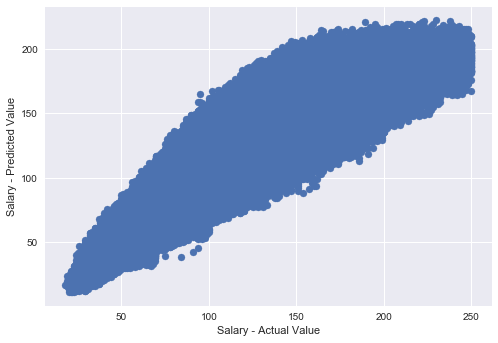

In [43]:
plt.scatter(y_train,y_hat)
plt.xlabel('Salary - Actual Value')
plt.ylabel('Salary - Predicted Value')
plt.show()

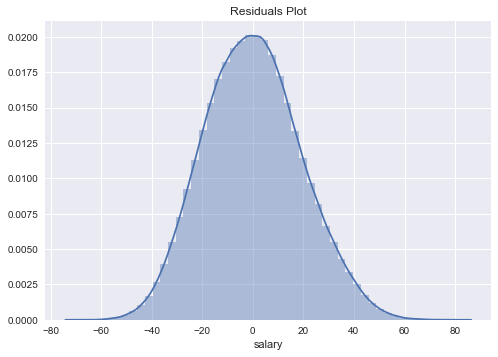

In [44]:
sns.distplot(y_train - y_hat)
plt.title("Residuals Plot")
plt.show()

#### R-squared & MSE Calculation

In [45]:
reg.score(x_train,y_train)

0.75316954287265703

In [46]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, y_hat)

364.09024636985345

#### Weights and Bias

In [47]:
reg_summary = pd.DataFrame(inputs.columns.values,columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,yearsExperience,13.509166
1,milesFromMetropolis,-10.845231
2,jobType_CFO,-3.059086
3,jobType_CTO,-3.080590
4,jobType_JANITOR,-18.721890
5,jobType_JUNIOR,-14.004099
6,jobType_MANAGER,-9.581530
7,jobType_SENIOR,-12.670230
8,jobType_VICE_PRESIDENT,-6.274100
9,degree_DOCTORAL,0.744393


## Testing the Linear Regression

In [48]:
y_hat_test = reg.predict(x_test)

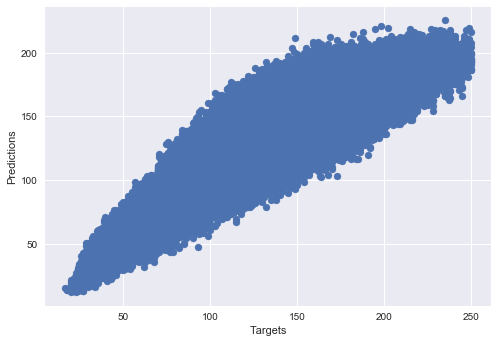

In [49]:
plt.scatter(y_test,y_hat_test)
plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.show()

In [50]:
df_pf = pd.DataFrame((y_hat_test),columns=['Prediction'])
y_test = y_test.reset_index(drop=True)
df_pf['Target'] = y_test
df_pf.head(5)

,Prediction,Target
0,77.407050,64
1,134.527854,172
2,130.924498,135
3,113.996743,109
4,169.665345,148


In [51]:
mean_squared_error(df_pf['Target'], df_pf['Prediction'])

363.94816858471944

## Trying Polynomial transformation

In [26]:
from sklearn.preprocessing import PolynomialFeatures
poly_trans = PolynomialFeatures(degree=2,interaction_only=True)
x_train_poly = poly_trans.fit_transform(x_train)
poly_trans

PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)

In [27]:
x_train_poly.shape

(790716, 529)

In [ ]:
poly = LinearRegression()
poly.fit(x_train_poly, y_train)

In [32]:
y_hat = poly.predict(x_train_poly)

ValueError: shapes (790716,561) and (33,) not aligned: 561 (dim 1) != 33 (dim 0)

In [29]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, y_hat)

426.42544926097935

In [ ]:
reg.score(x_train_poly,y_train)

In [86]:
from sklearn.linear_model import Ridge
RidgeModel = Ridge(alpha=1.0)
RidgeModel.fit(x_train_poly, y_train)
yhat_ridge_train = RidgeModel.predict(x_train_poly)
mean_squared_error(y_train, yhat_ridge_train)

307.9032898949569

## Testing the Polynomial Equation

## Ridge Regression

In [338]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1.0)
ridge_reg.fit(x_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [339]:
y_r_hat = ridge_reg.predict(x_train)

In [340]:
mean_squared_error(y_train, y_r_hat)

366.60207722623795